# CS448 - Lab 4: 3D Audio


In this lab we will learn how to create 3D sounds for headphone playback. We will make use of simple filters and HRTFs to create static and moving sources. Use the three sounds fly.wav, helicopter.wav, and crumble.wav in the lab archive as sources for the 3D recording that you will create.

In [3]:
### IMPORTS & SETUP ###

import matplotlib.pyplot as plt

import numpy as np
from scipy.io import wavfile
from scipy.signal import lfilter, convolve, fftconvolve

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (4, 3)

In [4]:
### UTILITIES ###


# Sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound(x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display(
        HTML('<style> table, th, td {border: 0px; }</style> <table><tr><td>' +
             label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:] +
             '</td></tr></table>'))


# Function that normalizes a signal
def normalize_signal(x):
    return x / np.max(np.abs(x))


# Function that plots the spectrogram of a sound
def plot_spectrogram(input_sound, fs, title="Spectrogram"):
    plt.title(title)
    plt.specgram(input_sound, Fs=fs, cmap="winter")
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    plt.show()

crumble.wav


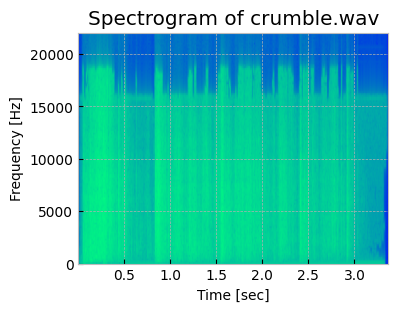

fly.wav


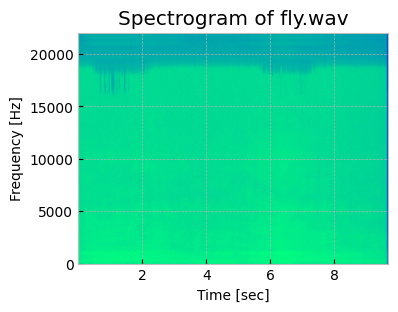

helicopter.wav


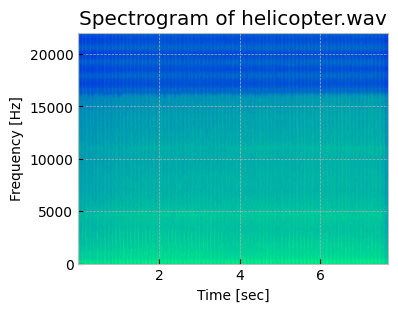

In [5]:
# Load the input sounds
fname_crumble = 'crumble.wav'
fs_crumble, input_sound_crumble = wavfile.read(f'./data/{fname_crumble}')
input_sound_crumble = normalize_signal(input_sound_crumble)

sound(input_sound_crumble, rate=fs_crumble, label=fname_crumble)
plot_spectrogram(input_sound_crumble, fs_crumble, title=f"Spectrogram of {fname_crumble}")

fname_fly = 'fly.wav'
fs_fly, input_sound_fly = wavfile.read(f'./data/{fname_fly}')
input_sound_fly = normalize_signal(input_sound_fly)

sound(input_sound_fly, rate=fs_fly, label=fname_fly)
plot_spectrogram(input_sound_fly, fs_fly, title=f"Spectrogram of {fname_fly}")

fname_heli = 'helicopter.wav'
fs_heli, input_sound_heli = wavfile.read(f'./data/{fname_heli}')
input_sound_heli = normalize_signal(input_sound_heli)

sound(input_sound_heli, rate=fs_heli, label=fname_heli)
plot_spectrogram(input_sound_heli, fs_heli, title=f"Spectrogram of {fname_heli}")

## Part 1: Static sources using ITD/ILD cues

Assume the following source locations: 

- Straight ahead

- 45 degrees to the left

- 80 degrees to the right

- 160 degrees to the left

For each location find the source’s delay between the two ears (assume a source distance of 2 meters), and design two filters that will simulate that ITD and ILD features (feel free to round the IDT delays to an integer sample size). Assume that when sounds come from the side of the head the attenuation at the contralateral ear is by a factor of 0.7. From sounds coming medial plane (between the ears) there will be no attenuation due to the head. For positions moving from the medial plane towards the sides you can interpolate between no attenuation and a factor of 0.7. Design and plot the filters that correspond to the locations shown above and use them to make 3D sounds with the following sounds:

- Crumbling paper: [https://drive.google.com/uc?export=download&id=1bsZArYwMftsuCLdMknRomz4kAJWT-Uhv ]

- Fly: [https://drive.google.com/uc?export=download&id=1bswUsI28yJOUQuNLvNxq3pu9qj0bb8ne ]

- Helicopter: [https://drive.google.com/uc?export=download&id=1c8YhNNLmaO7CA2dJNCkBsB9MY0HjHDRL ]

Listen to the result through headphones and verify that they sound somewhat localized (it won’t sound perfect, but it should be believable).  There is no need to render all three sounds, since the notebook will become very large and hard to upload.  At submission time just render one sound, but make sure that you listen to all three and that they sound good.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Part 2. Static sources using HRTFs

Download the HTTF archive from [https://drive.google.com/uc?export=download&id=1vFzSo-zlNFI-q2T9yvRRmOeZ-elZ8lW3 ]. In that directory you will also find code for the function load_hrtf which returns the left and right HRTF filters given as input a source’s azimuth and elevation. These filters will be much better than the ITD/ILD filters for localizing sounds.

Apply the HRTFs on the given sources and create 3D sounds that correspond to the locations given above. For each source, you will beed to convolve it with the left and right HRTF of the desired position and generate two sounds, one for each channel. Verify that they sound correct using headphones; are they better than before? What differences do you observe? When you use these make sure that the sample rates of the HRTFs and the sounds you convolve them with match.  The HRTFs are sampled at 44.1kHz.

Once again, just render one example before submission (the same as before so that we can compare).

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Part 3. Dynamic Sources with HRTFs

In this part you will need to make a moving sound source. In order to do so we will make use of a fast convolution routine based on your STFT code from lab 1 (ha, you thought you were done with that!). In order to perform fast convolution we can perform an STFT of the sound to use, multiply each time frame of this transform with the DFT of the filter that we want  to impose and then use overlap add to transform back to the time domain.

Start by taking each sound from above, and apply your STFT on it. Make sure that the size of the transform is the same as the HRTF’s filter length. The hop size should be the same as the DFT size and you will need to zero pad by as much as the DFT size in order to facilitate the tail of the convolution. Do not use an analysis/synthesis window.

Once you compute this STFT, go through its every time frame and element-wise multiply it with the desired HRTF filter to generate the STFT of the left and right sounds. Figure out which HRTF angle to multiply each frame with so that by the end of the sound you will have made it go around your head.

Once you perform these operations you will have generated two STFT matrices, one for the left channel and one for the right. Use your inverse STFT routine and play the stereo sound through your headphones. You should hear a convincing rendering of the original sounds circling around your head.

Submit only one of the sounds, but make sure you try it on all and that it sounds ok.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Part 4. Extra credit (required for 4-hour credit registrants)

Use the file in [https://drive.google.com/uc?export=download&id=1bxQkXcGa57S3G7IRWu9urS-jCPdf5Pif ] to make a short story. This is a 7-channel file of a scene from a really bad B-movie. Each channel contains a different sound. If you play that sound you probably won’t hear most of the content since you won’t have a 7 speaker setup, import it in a multi-channel editor such as Audacity and you will get a sense of what’s in there. Since it sounds so boring you need to add some reverb and 3D-locate the sounds so that it sounds more exciting. Try to make it sound better using what we have done so far. Keep in mind that you can add different amounts of reverb for each sound, and you can dynamically 3D place them as well.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()